In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import resample
from xgboost import XGBClassifier

warnings.simplefilter(action="ignore")
pd.set_option('display.max_columns', None)

In [11]:
# 1. 데이터 불러오기
df = pd.read_csv("C:/데이터 폴더/건강검진.csv")

In [12]:
df["Year_ID"] = df["YEAR"].astype(str) + "_" + df["ID"].astype(str)
cols = ['Year_ID'] + [col for col in df.columns if col != 'Year_ID']
df = df[cols]
df = df.drop(['ID', 'YEAR'], axis=1)

In [13]:
# 2. 라벨 맵핑
df['OBESITY'] = df['OBESITY'].map({'normal': 0, 'pre': 1, 'class1': 2, 'class2': 3, 'class3': 4})
df['DIABETES'] = df['DIABETES'].map({'normal': 0, 'pre': 1, 'diabetes': 2})
df['HYPERTENSION'] = df['HYPERTENSION'].map({'normal': 0, 'pre': 1, 'stage1': 2, 'stage2': 3})
binary_cols = ['DYSLIPIDEMIA', 'LIVER_ABNORMAL', 'KIDNEY_ABNORMAL', 'ANEMIA']
for col in binary_cols:
    df[col] = df[col].map({False: 0, True: 1})

In [14]:
# 3. 입력 변수 정의 및 정규화
input_features = ["HEIGHT", "WEIGHT", "WAIST", "BP_HIGH", "BP_LWST", 
                  "BLDS", "TOT_CHOLE", "TRIGLYCERIDE", "HDL_CHOLE", 
                  "LDL_CHOLE", "HMG", "OLIG_PROTE_CD", "CREATININE", 
                  "SGOT_AST", "SGPT_ALT", "GAMMA_GTP", "SMK_STAT_TYPE_CD", 
                  "DRK_YN", "BMI"]

scaler = RobustScaler()
df[input_features] = scaler.fit_transform(df[input_features])

In [6]:
#<XGBoost>
# 4. 타겟 분리 및 BMI 제거
target = 'OBESITY'
X = df.drop(columns=[target, 'BMI', 'WEIGHT','Year_ID'])

scaler = StandardScaler()
X= scaler.fit_transform(X)
Y = df[target]

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2)

# 9. XGBoost 학습 및 예측
model = XGBClassifier(
    objective='multi:softmax',
    num_class=5,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)


KeyboardInterrupt: 

In [34]:
# 10. 성능 평가
print("Confusion Matrix:")
print(confusion_matrix(Y_test, y_pred))
print("\nClassification Report:")
print(classification_report(Y_test, y_pred))

Confusion Matrix:
[[165583  18328  14098     26      4]
 [ 31155  31073  30976     48      3]
 [ 15397  18092 122461   4096     38]
 [    69    132  12004   9502    699]
 [     6      5    340   1675   1493]]

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.84      0.81    198039
           1       0.46      0.33      0.39     93255
           2       0.68      0.76      0.72    160084
           3       0.62      0.42      0.50     22406
           4       0.67      0.42      0.52      3519

    accuracy                           0.69    477303
   macro avg       0.64      0.56      0.59    477303
weighted avg       0.68      0.69      0.68    477303



클래스 0 예측 good
클래스 1 예측 bad (높은 false positive와 낮은 recall이 문제)
클래스 2 so so
클래스 3 too bad (특히 recall이 낮음)
클래스 4 클래스 수가 너무 작음

In [15]:
print(df["OBESITY"].value_counts())

OBESITY
0    989724
2    799269
1    467218
3    112755
4     17547
Name: count, dtype: int64


In [8]:
#<XGBoost+SMOTE> - 클래스 균형 맞추기추기
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import xgboost as xgb

# 데이터 준비
X = df.drop(["OBESITY", 'BMI', 'WEIGHT','Year_ID'], axis=1)
y = df["OBESITY"]

# SMOTE 적용하여 클래스 불균형 해결
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# 학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# XGBoost 모델 학습
model = xgb.XGBClassifier(objective="multi:softmax", num_class=5, scale_pos_weight=[class_weights[i] for i in range(5)])
model.fit(X_train, y_train)

# 예측 및 평가
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


NameError: name 'class_weights' is not defined

전보다 개선됨.

In [25]:
print(df["OBESITY"].value_counts())

OBESITY
0    989724
2    799269
1    467218
3    112755
4     17547
Name: count, dtype: int64


In [ ]:
#<lightGBM + SMOTE>
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import lightgbm as lgb

# 특성과 타겟 설정
X = df.drop(["OBESITY", "BMI", "WEIGHT","Year_ID"], axis=1)
y = df["OBESITY"]

# SMOTE 적용
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# 학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# LightGBM 모델 학습
lgbm_model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=5,
    class_weight='balanced',  # 불균형 대응
    random_state=42
)
lgbm_model.fit(X_train, y_train)

# 예측 및 평가
y_pred = lgbm_model.predict(X_test)
print(classification_report(y_test, y_pred))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.111198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4394
[LightGBM] [Info] Number of data points in the train set: 3958896, number of used features: 26
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
              precision    recall  f1-score   support

           0       0.79      0.81      0.80    197945
           1       0.67      0.68      0.68    197944
           2       0.67      0.64      0.65    197945
           3       0.76      0.76      0.76    197945
           4       0.86      0.85      0.86    197945

    accuracy                           0.75    98

In [ ]:
#<lightGBM + SMOTE + features importance 낮은 변수들 제거>
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
targets = ['OBESITY','DYSLIPIDEMIA','DIABETES','HYPERTENSION','LIVER_ABNORMAL','KIDNEY_ABNORMAL','ANEMIA']
# 특성과 타겟 설정
X = df.drop(columns=targets + ['BMI',"WEIGHT",'Year_ID'])
y = df["OBESITY"]

# SMOTE 적용
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# 학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# LightGBM 모델 학습
lgbm_model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=5,
    class_weight='balanced',  # 불균형 대응
    random_state=42
)
lgbm_model.fit(X_train, y_train)

# 예측 및 평가
y_pred = lgbm_model.predict(X_test)
print(classification_report(y_test, y_pred))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4378
[LightGBM] [Info] Number of data points in the train set: 3958896, number of used features: 20
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
              precision    recall  f1-score   support

           0       0.79      0.81      0.80    197945
           1       0.67      0.68      0.68    197944
           2       0.67      0.64      0.65    197945
           3       0.75      0.76      0.76    197945
           4       0.86      0.85      0.85    197945

    accuracy                           0.75    98

In [26]:
#<lightGBM + SMOTE(Train에만) + features importance 낮은 변수들 제거>
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
targets = ['OBESITY','DYSLIPIDEMIA','DIABETES','HYPERTENSION','LIVER_ABNORMAL','KIDNEY_ABNORMAL','ANEMIA']
# 특성과 타겟 설정
X = df.drop(columns=targets + ['BMI',"WEIGHT",'Year_ID'])
y = df["OBESITY"]


# 학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# SMOTE 적용
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled  = smote.fit_resample(X_train, y_train)

# LightGBM 모델 학습
lgbm_model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=5,
    class_weight='balanced',  # 불균형 대응
    random_state=42
)
lgbm_model.fit(X_train_resampled, y_train_resampled)

# 예측 및 평가
y_pred = lgbm_model.predict(X_test)
print(classification_report(y_test, y_pred))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.133243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4381
[LightGBM] [Info] Number of data points in the train set: 3958895, number of used features: 20
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
              precision    recall  f1-score   support

           0       0.79      0.81      0.80    197945
           1       0.45      0.40      0.42     93444
           2       0.69      0.71      0.70    159854
           3       0.52      0.44      0.48     22551
           4       0.42      0.71      0.53      3509

    accuracy                           0.68    477303
   macro avg       0.57      0.62      0.59    477303
weigh

smote를 train에만 하는게 맞고 했지만 정답률이 떨어진다

In [27]:
print(df["OBESITY"].value_counts())

OBESITY
0    989724
2    799269
1    467218
3    112755
4     17547
Name: count, dtype: int64


In [9]:
#<lightGBM + SMOTE(Train에만 자동이 아닌 각 클래스별 수동으로 조정) + features importance 낮은 변수들 제거>
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import lightgbm as lgb

# 타겟 및 불필요한 변수 제거
targets = ['OBESITY', 'DYSLIPIDEMIA', 'DIABETES', 'HYPERTENSION', 'LIVER_ABNORMAL', 'KIDNEY_ABNORMAL', 'ANEMIA']
X = df.drop(columns=targets + ['BMI', 'WEIGHT', 'Year_ID'])
y = df['OBESITY']

# 학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# SMOTE 수동 적용
smote = SMOTE(
    sampling_strategy={
        1: 600000,   # 비만 전단계
        3: 200000,   # 비만
        4: 80000     # 고도비만
    },
    random_state=42
)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# LightGBM 모델 정의 (하이퍼파라미터 반영)
lgbm_model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=5,
    class_weight='balanced',
    learning_rate=0.05,
    n_estimators=500,
    max_depth=10,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# 모델 학습
lgbm_model.fit(X_train_resampled, y_train_resampled)

# 예측 및 평가
y_pred = lgbm_model.predict(X_test)
print(classification_report(y_test, y_pred))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4374
[LightGBM] [Info] Number of data points in the train set: 2311194, number of used features: 20
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
              precision    recall  f1-score   support

           0       0.82      0.78      0.80    197945
           1       0.44      0.46      0.45     93444
           2       0.70      0.67      0.68    159854
           3       0.45      0.62      0.52     22551
           4       0.47      0.67      0.55      3509

    accuracy                           0.67    47

In [ ]:
#<lightGBM + SMOTE(Train에만 자동이 아닌 각 클래스별 수동으로 조정 + class weight 수동설정정 ) + features importance 낮은 변수들 제거>
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import lightgbm as lgb

# 타겟 및 불필요한 변수 제거
targets = ['OBESITY', 'DYSLIPIDEMIA', 'DIABETES', 'HYPERTENSION', 'LIVER_ABNORMAL', 'KIDNEY_ABNORMAL', 'ANEMIA']
X = df.drop(columns=targets + ['BMI', 'WEIGHT', 'Year_ID'])
y = df['OBESITY']

# 학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# SMOTE 수동 적용
smote = SMOTE(
    sampling_strategy={
        1: 600000,   # 비만 전단계
        3: 200000,   # 비만
        4: 80000     # 고도비만
    },
    random_state=42
)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# LightGBM 모델 정의 (하이퍼파라미터 반영)
lgbm_model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=5,
    class_weight={0:1, 1:2, 2:2, 3:3, 4:3},  
    learning_rate=0.05,
    n_estimators=500,
    max_depth=10,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)


# 모델 학습
lgbm_model.fit(X_train_resampled, y_train_resampled)

# 예측 및 평가
y_pred = lgbm_model.predict(X_test)
print(classification_report(y_test, y_pred))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4374
[LightGBM] [Info] Number of data points in the train set: 2311194, number of used features: 20
[LightGBM] [Info] Start training from score -1.647044
[LightGBM] [Info] Start training from score -1.231250
[LightGBM] [Info] Start training from score -1.167626
[LightGBM] [Info] Start training from score -1.924397
[LightGBM] [Info] Start training from score -2.840688
              precision    recall  f1-score   support

           0       0.87      0.69      0.77    197945
           1       0.42      0.53      0.47     93444
           2       0.68      0.75      0.71    159854
           3       0.57      0.52      0.54     22551
           4       0.61      0.51      0.56      3509

    accuracy                           0.67    47

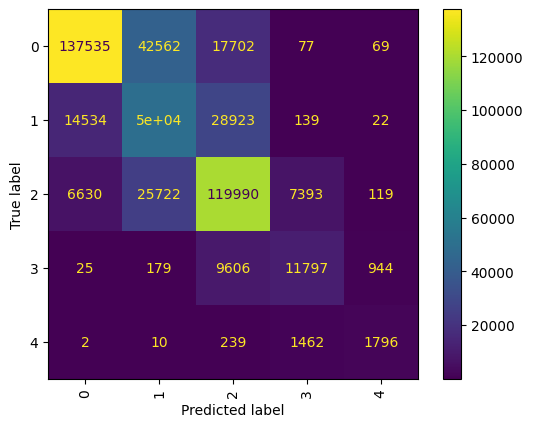

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation='vertical')
plt.show()


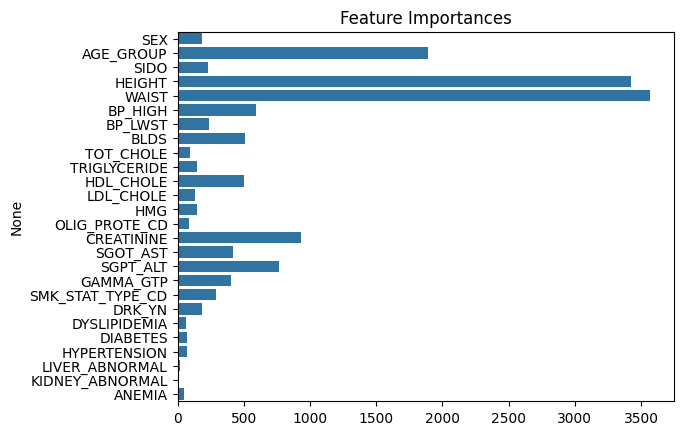

In [75]:
sns.barplot(
    x=lgbm_model.feature_importances_,
    y=X.columns
)
plt.title("Feature Importances")
plt.show()


각 질병 별 상관계수와 feature imprtances 확인해야 할 듯.

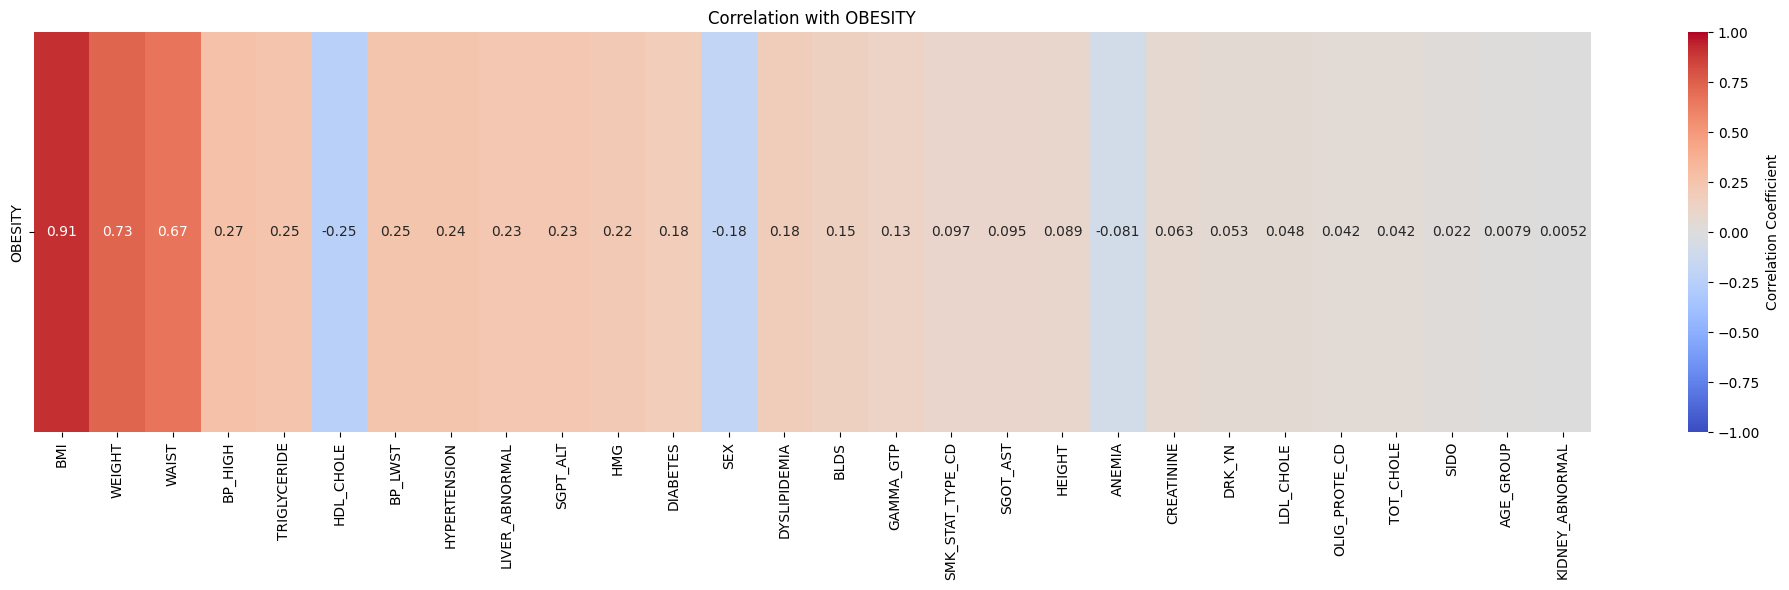

In [90]:
#OBESITY 상관관계
import seaborn as sns
import matplotlib.pyplot as plt

# 상관계수 행렬 계산
corr_matrix = df.corr(numeric_only=True)

# OBESITY 다른 변수들 간의 상관관계 추출
corr_with_target = corr_matrix[["OBESITY"]].drop("OBESITY").sort_values(by="OBESITY", key=abs, ascending=False)

# 히트맵 시각화
plt.figure(figsize=(20, 6))
sns.heatmap(corr_with_target.T, annot=True, cmap="coolwarm", vmin=-1, vmax=1, cbar_kws={'label': 'Correlation Coefficient'})
plt.title("Correlation with OBESITY")
plt.tight_layout()
plt.show()


<DYSLIPIDEMIA>

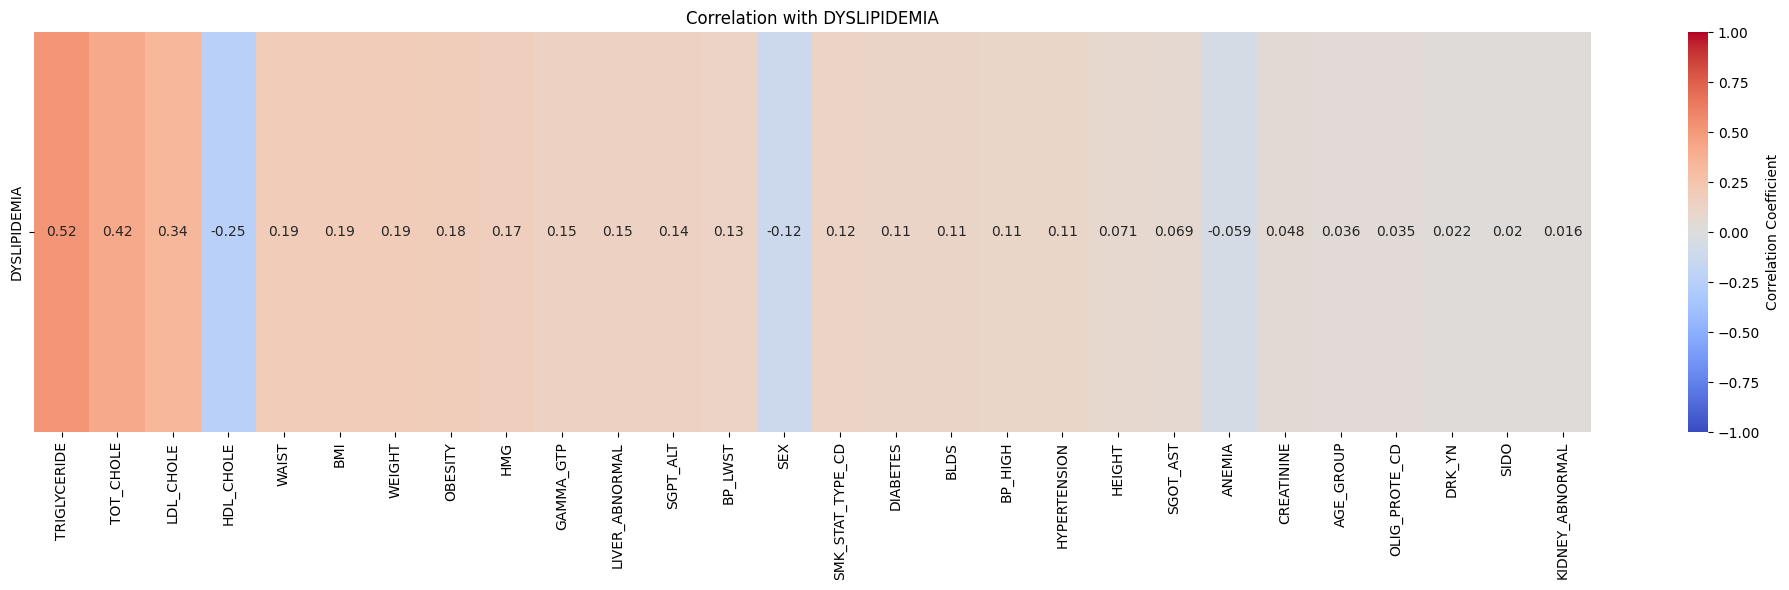

In [96]:
#DYSLIPIDEMIA 상관관계
import seaborn as sns
import matplotlib.pyplot as plt

# 상관계수 행렬 계산
corr_matrix = df.corr(numeric_only=True)

# DYSLIPIDEMIA와 다른 변수들 간의 상관관계 추출
corr_with_target = corr_matrix[["DYSLIPIDEMIA"]].drop("DYSLIPIDEMIA").sort_values(by="DYSLIPIDEMIA", key=abs, ascending=False)

# 히트맵 시각화
plt.figure(figsize=(20, 6))
sns.heatmap(corr_with_target.T, annot=True, cmap="coolwarm", vmin=-1, vmax=1, cbar_kws={'label': 'Correlation Coefficient'})
plt.title("Correlation with DYSLIPIDEMIA")
plt.tight_layout()
plt.show()


In [20]:
print(df["DYSLIPIDEMIA"].value_counts())

DYSLIPIDEMIA
0    1649648
1     736865
Name: count, dtype: int64


In [28]:
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

# 데이터 준비
targets = ['OBESITY', 'DYSLIPIDEMIA', 'DIABETES', 'HYPERTENSION', 'LIVER_ABNORMAL', 'KIDNEY_ABNORMAL', 'ANEMIA']
X = df.drop(columns=targets + ['Year_ID','TRIGLYCERIDE'])
y = df["DYSLIPIDEMIA"]

# 학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 이진 분류에서 클래스 가중치 계산
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)

# XGBoost 모델 학습 (이진 분류)
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# 예측 및 평가
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      1.00      1.00    329930
           1       0.99      0.98      0.99    147373

    accuracy                           0.99    477303
   macro avg       0.99      0.99      0.99    477303
weighted avg       0.99      0.99      0.99    477303



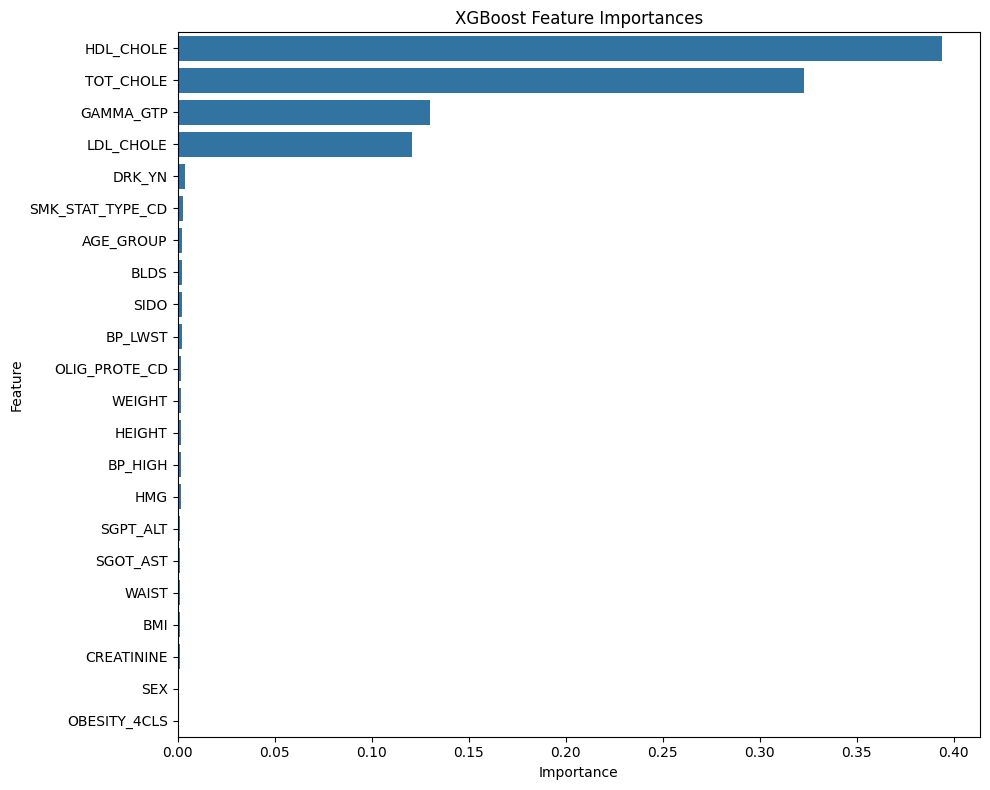

In [31]:
# 특성 중요도 추출
importances = model.feature_importances_
feature_names = X.columns

# 중요도를 DataFrame으로 정리
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 시각화
plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title("XGBoost Feature Importances")
plt.tight_layout()
plt.show()


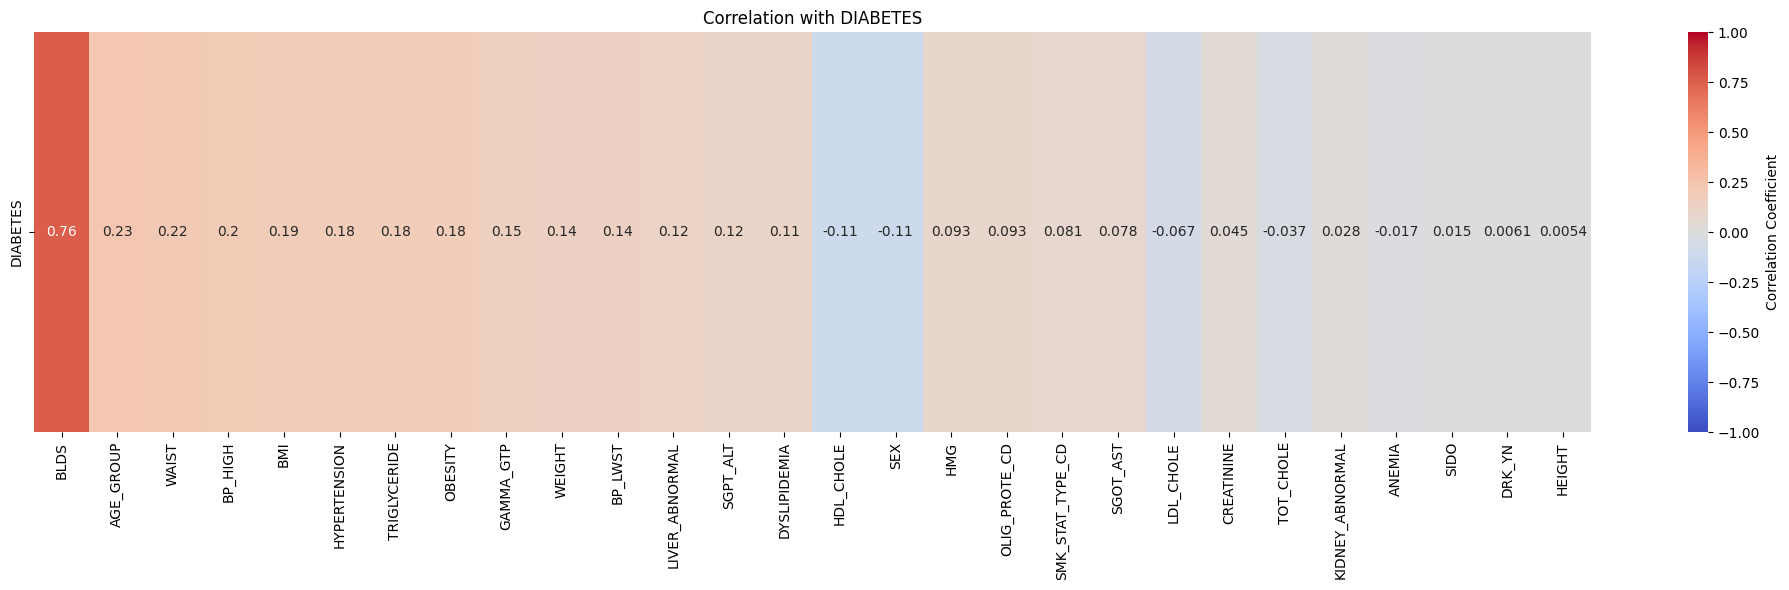

In [91]:
#DIABETES 상관관계
import seaborn as sns
import matplotlib.pyplot as plt

# 상관계수 행렬 계산
corr_matrix = df.corr(numeric_only=True)

# DIABETES 다른 변수들 간의 상관관계 추출
corr_with_target = corr_matrix[["DIABETES"]].drop("DIABETES").sort_values(by="DIABETES", key=abs, ascending=False)

# 히트맵 시각화
plt.figure(figsize=(20, 6))
sns.heatmap(corr_with_target.T, annot=True, cmap="coolwarm", vmin=-1, vmax=1, cbar_kws={'label': 'Correlation Coefficient'})
plt.title("Correlation with DIABETES")
plt.tight_layout()
plt.show()


In [ ]:
# 데이터 준비
targets = ['OBESITY', 'DYSLIPIDEMIA', 'DIABETES', 'HYPERTENSION', 'LIVER_ABNORMAL', 'KIDNEY_ABNORMAL', 'ANEMIA']
X = df.drop(columns=targets + ['Year_ID','TRIGLYCERIDE'])
y = df["DYSLIPIDEMIA"]

# 학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 이진 분류에서 클래스 가중치 계산
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)

# XGBoost 모델 학습 (이진 분류)
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# 예측 및 평가
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


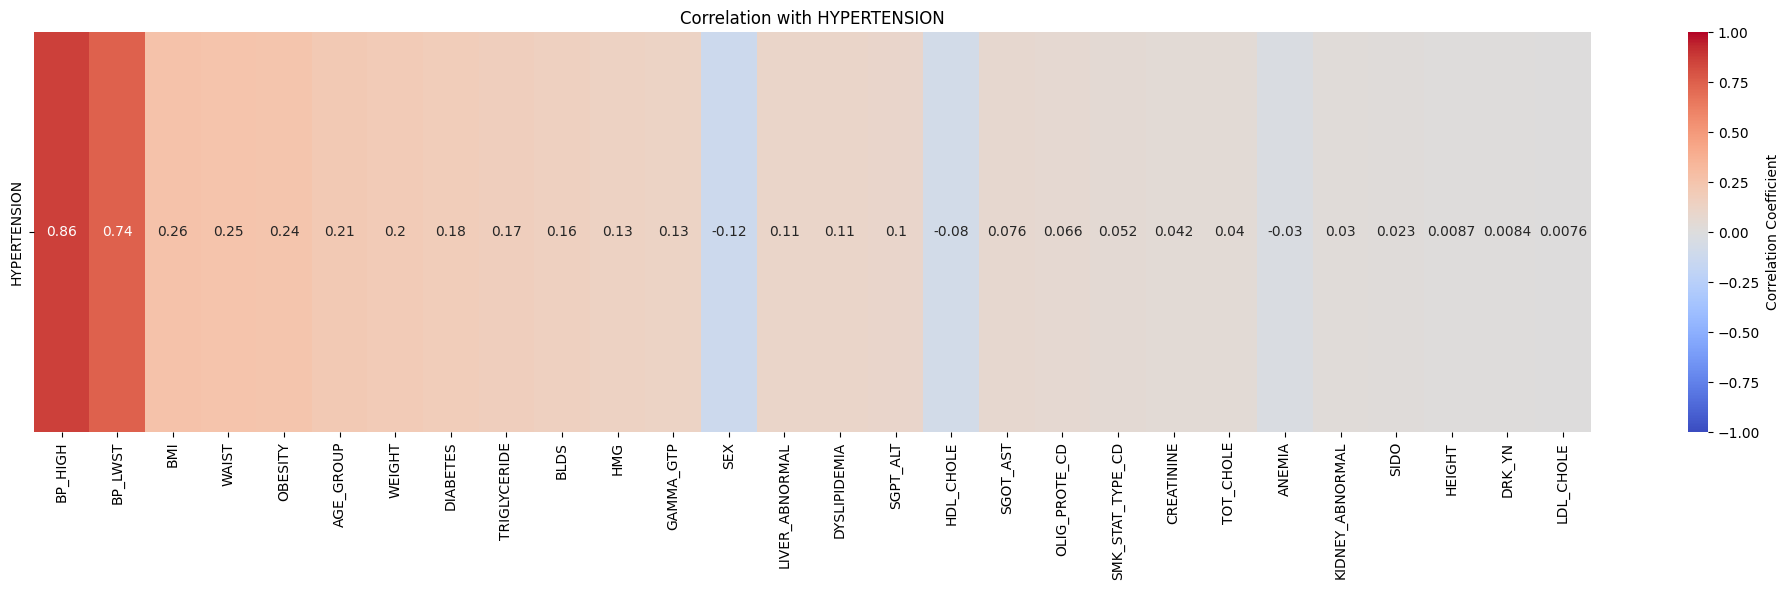

In [92]:
#HYPERTENSION 상관관계
import seaborn as sns
import matplotlib.pyplot as plt

# 상관계수 행렬 계산
corr_matrix = df.corr(numeric_only=True)

# HYPERTENSION 다른 변수들 간의 상관관계 추출
corr_with_target = corr_matrix[["HYPERTENSION"]].drop("HYPERTENSION").sort_values(by="HYPERTENSION", key=abs, ascending=False)

# 히트맵 시각화
plt.figure(figsize=(20, 6))
sns.heatmap(corr_with_target.T, annot=True, cmap="coolwarm", vmin=-1, vmax=1, cbar_kws={'label': 'Correlation Coefficient'})
plt.title("Correlation with HYPERTENSION")
plt.tight_layout()
plt.show()


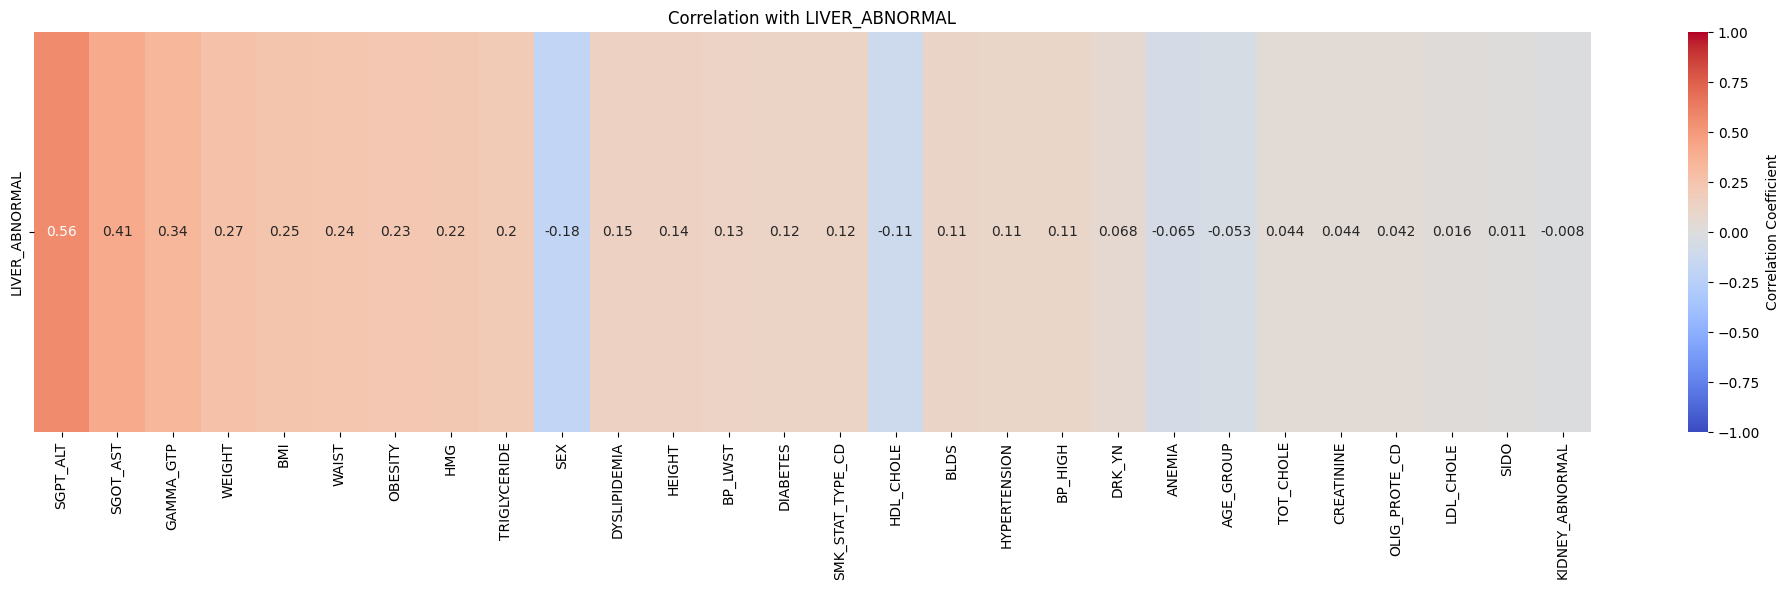

In [93]:
#LIVER_ABNORMAL 상관관계
import seaborn as sns
import matplotlib.pyplot as plt

# 상관계수 행렬 계산
corr_matrix = df.corr(numeric_only=True)

# LIVER_ABNORMAL 다른 변수들 간의 상관관계 추출
corr_with_target = corr_matrix[["LIVER_ABNORMAL"]].drop("LIVER_ABNORMAL").sort_values(by="LIVER_ABNORMAL", key=abs, ascending=False)

# 히트맵 시각화
plt.figure(figsize=(20, 6))
sns.heatmap(corr_with_target.T, annot=True, cmap="coolwarm", vmin=-1, vmax=1, cbar_kws={'label': 'Correlation Coefficient'})
plt.title("Correlation with LIVER_ABNORMAL")
plt.tight_layout()
plt.show()


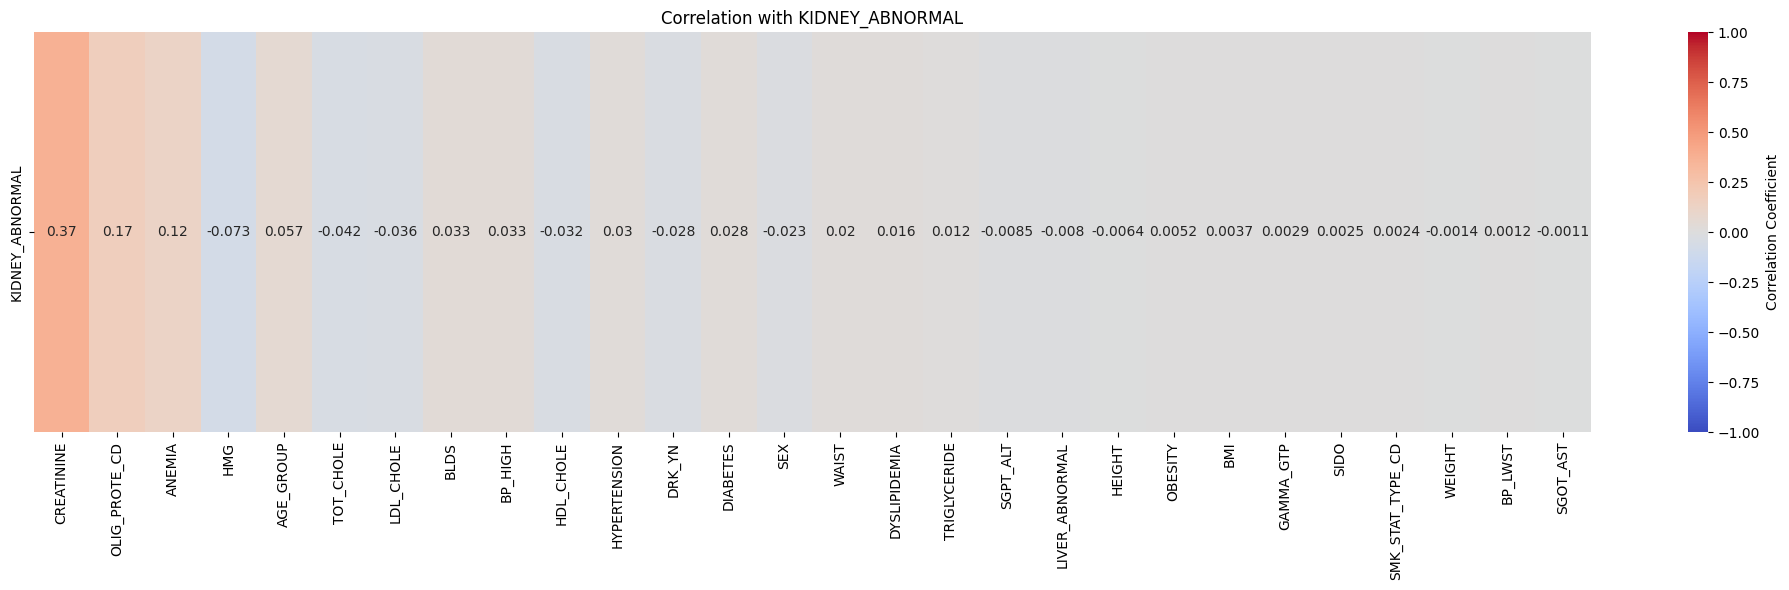

In [94]:
#KIDNEY_ABNORMAL 상관관계
import seaborn as sns
import matplotlib.pyplot as plt

# 상관계수 행렬 계산
corr_matrix = df.corr(numeric_only=True)

# KIDNEY_ABNORMAL 다른 변수들 간의 상관관계 추출
corr_with_target = corr_matrix[["KIDNEY_ABNORMAL"]].drop("KIDNEY_ABNORMAL").sort_values(by="KIDNEY_ABNORMAL", key=abs, ascending=False)

# 히트맵 시각화
plt.figure(figsize=(20, 6))
sns.heatmap(corr_with_target.T, annot=True, cmap="coolwarm", vmin=-1, vmax=1, cbar_kws={'label': 'Correlation Coefficient'})
plt.title("Correlation with KIDNEY_ABNORMAL")
plt.tight_layout()
plt.show()


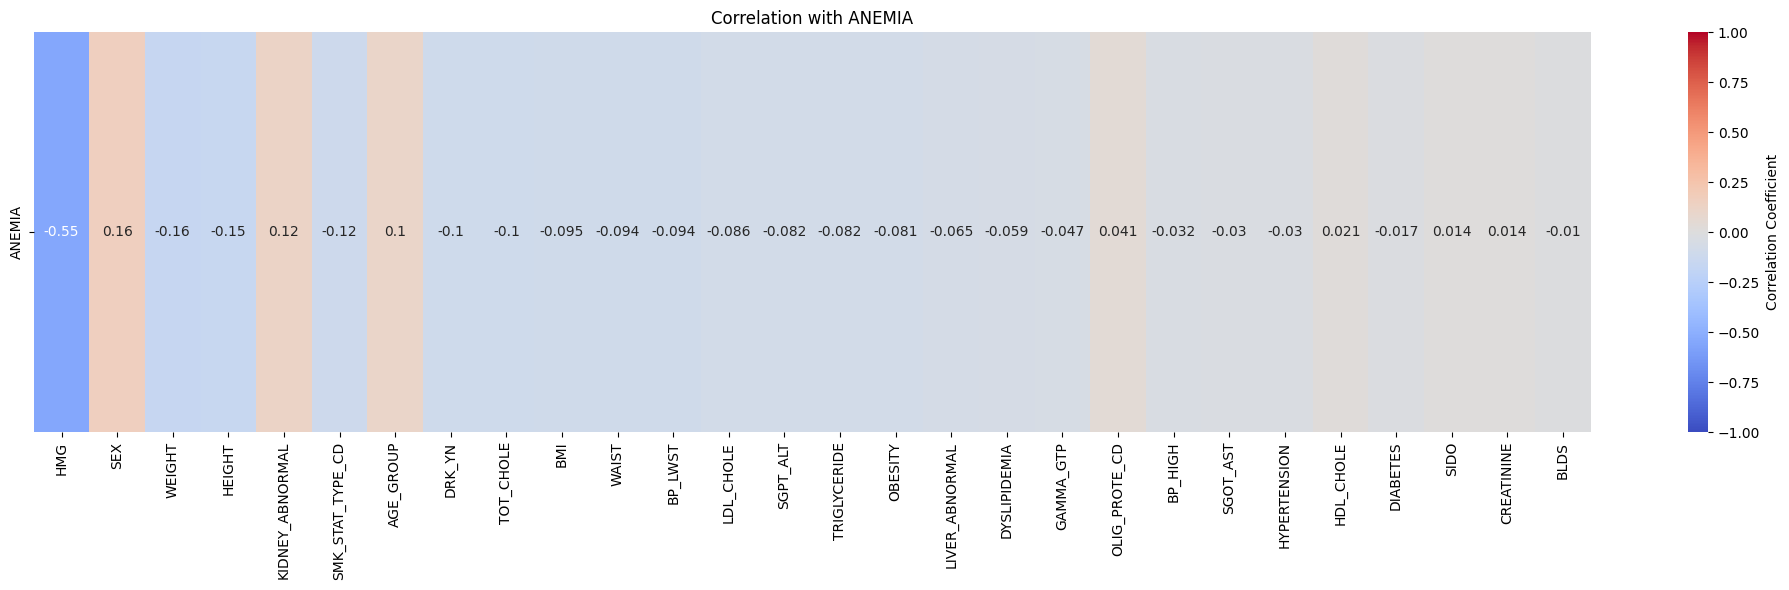

In [95]:
#ANEMIA 상관관계
import seaborn as sns
import matplotlib.pyplot as plt

# 상관계수 행렬 계산
corr_matrix = df.corr(numeric_only=True)

# ANEMIA 다른 변수들 간의 상관관계 추출
corr_with_target = corr_matrix[["ANEMIA"]].drop("ANEMIA").sort_values(by="ANEMIA", key=abs, ascending=False)

# 히트맵 시각화
plt.figure(figsize=(20, 6))
sns.heatmap(corr_with_target.T, annot=True, cmap="coolwarm", vmin=-1, vmax=1, cbar_kws={'label': 'Correlation Coefficient'})
plt.title("Correlation with ANEMIA")
plt.tight_layout()
plt.show()


미래 예측(DYSLIPIDEMIA)

In [ ]:
# 질병 없는 사람 데이터 준비 (TRIGLYCERIDE 컬럼 제외)
X_unlabeled = X[y == 0].copy()

# 모델 예측
y_prob = model.predict_proba(X_unlabeled)[:, 1]

# risk_score 계산 및 추가
X_unlabeled["risk_score"] = y_prob

# 고위험군 설정 (risk_score >= 0.8인 사람들)
high_risk = X_unlabeled[X_unlabeled["risk_score"] >= 0.8]

# Dyslipidemia targets (cholesterol guidelines)
Dyslipidemia_targets = {
    'TOT_CHOLE': 240,
    'HDL_CHOLE': 40,
    'LDL_CHOLE': 160
}

for col, threshold in Dyslipidemia_targets.items():
    plt.figure(figsize=(8, 4))
    sns.kdeplot(data=X_unlabeled, x=col, label='Normal (No disease)')
    sns.kdeplot(data=high_risk, x=col, label='High risk', color='red')
    plt.axvline(threshold, color='black', linestyle='--', label=f'{col} threshold')
    plt.title(f'{col} Distribution (High risk vs Normal)')
    plt.legend()
    plt.show()

